INFO:root:Loading data for BTC
INFO:root:Loaded 2465 rows for BTC
INFO:root:Loading data for ETH
INFO:root:Loaded 2465 rows for ETH
INFO:root:Loading data for BNB
INFO:root:Loaded 2464 rows for BNB
INFO:root:Loading data for XRP
INFO:root:Loaded 2465 rows for XRP
INFO:root:Loading data for ADA
INFO:root:Loaded 2465 rows for ADA
INFO:root:Loading data for DOGE
INFO:root:Loaded 2465 rows for DOGE
INFO:root:Loading data for SOL
INFO:root:Loaded 1636 rows for SOL
INFO:root:Loading data for TON
INFO:root:Loaded 1131 rows for TON
INFO:root:Loading data for TRX
INFO:root:Loaded 2465 rows for TRX
INFO:root:Loading data for AVAX
INFO:root:Loaded 1469 rows for AVAX
INFO:root:Forward filling and dropping NaN values in the price data.
INFO:root:Price Data Date Range: 2021-08-27 00:00:00 to 2024-09-30 00:00:00
INFO:root:Price Data Head:
                   BTC        ETH       BNB       XRP       ADA      DOGE   
Start                                                                       
2021-08-27

Sharpe Ratio: 1.3011
Beta: 0.0209
Alpha: 0.0058


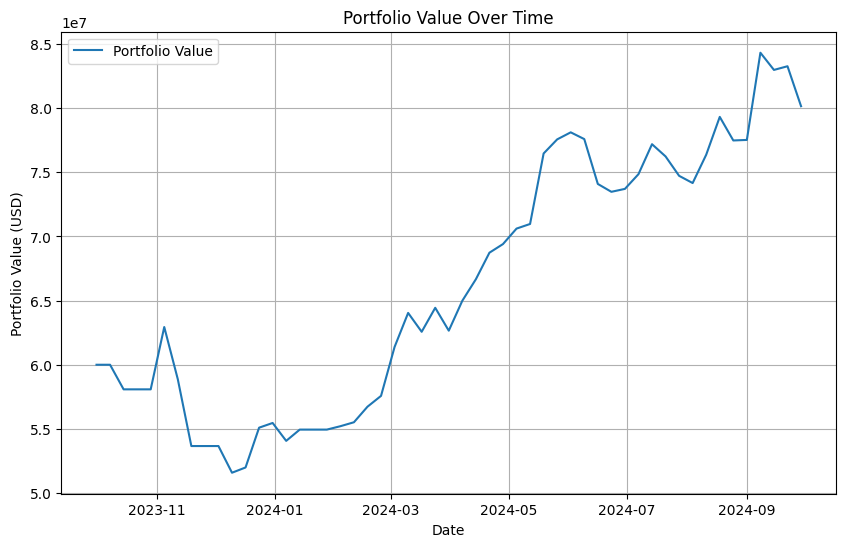

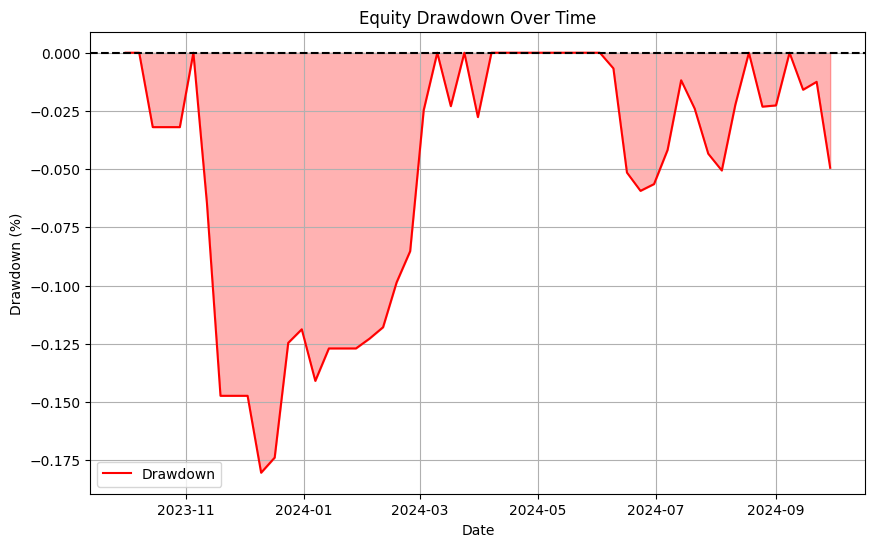

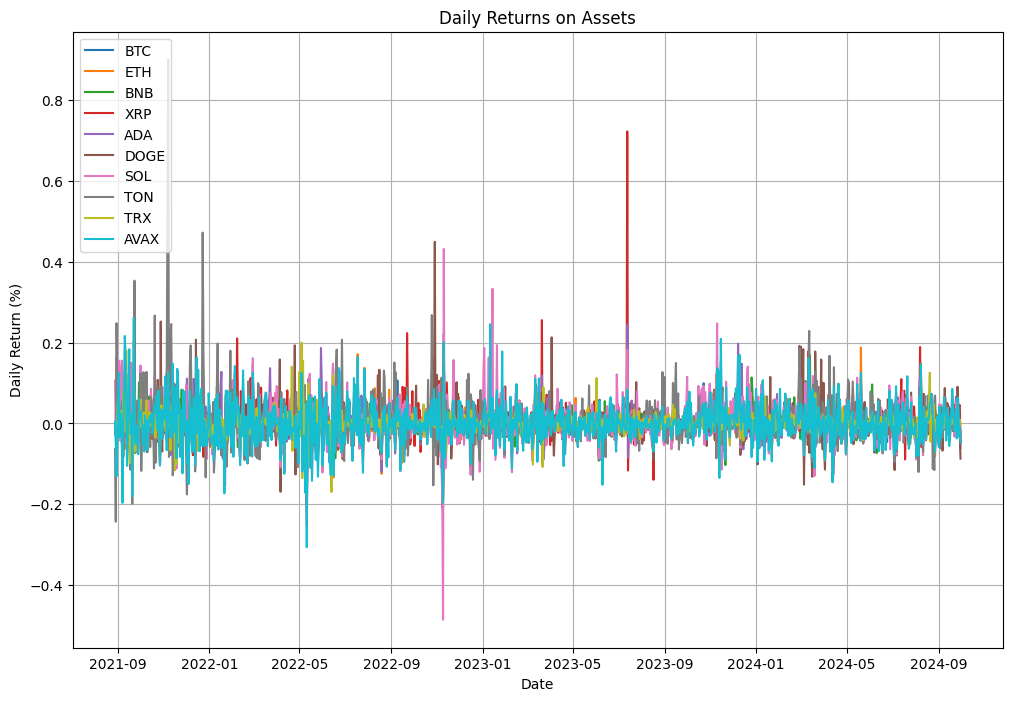

In [27]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
import statsmodels.api as sm
import yfinance as yf

# Logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load price and market cap data from CSV files
def load_price_and_market_cap_data(folder_path, coins):
    price_data = {}
    market_cap_data = {}
    
    for coin in coins:
        logging.info(f"Loading data for {coin}")
        file_path = os.path.join(folder_path, f"{coin}.csv")
        df = pd.read_csv(file_path, parse_dates=['Start'], index_col='Start')
        
        # Log the number of loaded rows for this coin
        logging.info(f"Loaded {len(df)} rows for {coin}")
        
        # Store close prices for price data
        price_data[coin] = df['Close']
        
        # Store market cap data
        market_cap_data[coin] = df[['Market Cap', 'Volume']]
    
    # Convert dictionaries to DataFrames
    price_data = pd.DataFrame(price_data)

    # Handle missing values in price data (forward fill or drop)
    logging.info("Forward filling and dropping NaN values in the price data.")
    price_data.ffill(inplace=True)  # Forward fill missing values
    price_data.dropna(inplace=True)  # Drop rows with persistent NaN values

    # Log the date range of the price data
    logging.info(f"Price Data Date Range: {price_data.index.min()} to {price_data.index.max()}")
    
    # Check if we have data for the required backtest period
    if price_data.index.min() > pd.to_datetime(start_date) or price_data.index.max() < pd.to_datetime(end_date):
        logging.warning(f"Price data does not cover the full backtest period from {start_date} to {end_date}")

    market_cap_data = {coin: df for coin, df in market_cap_data.items()}
    
    logging.info(f"Price Data Head:\n{price_data.head()}")
    return price_data, market_cap_data

# Define factor calculation (Momentum, Size, Value)
def calculate_factors(price_data, cap_data, rolling_window=7):
    logging.info("Calculating factors (Momentum, Size, Value)")

    # Momentum: past week return
    momentum = price_data.pct_change(rolling_window).shift(1)
    logging.info(f"Momentum head:\n{momentum.head()}")

    # Size: market cap of the coins
    size = pd.DataFrame({coin: cap_data[coin]['Market Cap'] for coin in cap_data})
    logging.info(f"Size head:\n{size.head()}")

    # Value: inverse of NVT ratio (Market Cap / Volume)
    value = pd.DataFrame({coin: cap_data[coin]['Market Cap'] / cap_data[coin]['Volume'] for coin in cap_data})
    
    # Handle potential divide-by-zero or inf values in NVT ratio
    value.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN
    value.fillna(0, inplace=True)  # Replace NaN values with 0 or another strategy
    logging.info(f"Value (NVT) head before inversion:\n{value.head()}")

    value = 1 / value
    value = value.clip(lower=-1e9, upper=1e9)  # Clip values to a reasonable range
    logging.info(f"Value (after inversion and clipping) head:\n{value.head()}")
    
    return momentum, size, value

# Backtest strategy with dynamic long/short based on signal strength and sentiment
def backtest_strategy(start_date, end_date, initial_investment, price_data, cap_data, rebalance_time='00:00'):
    logging.info("Starting backtest")
    # Initialize portfolio metrics
    portfolio_value = initial_investment
    portfolio_history = []
    returns_history = []
    
    dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    logging.info(f"Backtest dates: {dates}")
    
    # Calculate factors
    momentum, size, value = calculate_factors(price_data, cap_data)

    # Standardize factors (handle NaN and inf values)
    scaler = StandardScaler()
    
    # Apply StandardScaler while handling NaN values
    logging.info("Standardizing factors.")
    momentum_std = pd.DataFrame(scaler.fit_transform(momentum.fillna(0)), index=momentum.index, columns=momentum.columns)
    size_std = pd.DataFrame(scaler.fit_transform(size.fillna(0)), index=size.index, columns=size.columns)
    value_std = pd.DataFrame(scaler.fit_transform(value.fillna(0)), index=value.index, columns=value.columns)
    
    # Combine factors (equal weight)
    combined_signal = (momentum_std + size_std + value_std) / 3
    logging.info(f"Combined signal head:\n{combined_signal.head()}")
    
    # Restrict signals to the backtest period (starting from start_date)
    combined_signal = combined_signal.loc[start_date:end_date]
    
    for date in dates:
        # Use only the date without time
        portfolio_date = date
        logging.info(f"Rebalancing for date: {portfolio_date}")
        
        if portfolio_date in combined_signal.index:
            signals = combined_signal.loc[portfolio_date]
            logging.info(f"Signals on {portfolio_date}:\n{signals}")
            
            # Check if there are any valid signals
            if signals.isna().all():
                logging.warning(f"No valid signals on {portfolio_date}. Skipping this date.")
                # Append current portfolio value and zero return
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue
            
            # Split signals dynamically based on their strength
            long_threshold = 0.5  # Go long if signal > 0.5
            short_threshold = -0.5  # Go short if signal < -0.5
            
            # Dynamic long/short allocation based on signal strength
            long_coins = signals[signals > long_threshold].index
            short_coins = signals[signals < short_threshold].index
            
            # If no strong short signals, skip shorting
            if len(short_coins) == 0:
                logging.info(f"No strong short signals on {portfolio_date}. Not shorting.")
            
            # If no strong long signals, skip longing
            if len(long_coins) == 0:
                logging.info(f"No strong long signals on {portfolio_date}. Not longing.")
            
            # Ensure there are coins to long or short
            if len(long_coins) == 0 and len(short_coins) == 0:
                logging.warning(f"No strong signals to act upon on {portfolio_date}. Skipping.")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue
            
            # Compute value-weighted allocation
            total_market_cap = size.loc[portfolio_date, long_coins].sum() if len(long_coins) > 0 else 1
            weights = size.loc[portfolio_date, long_coins] / total_market_cap if len(long_coins) > 0 else pd.Series(0, index=long_coins)
            
            # Log market cap and weights for long positions
            logging.info(f"Market cap for long coins:\n{size.loc[portfolio_date, long_coins]}")
            logging.info(f"Weights for long positions:\n{weights}")

            try:
                # Find the next trading day after portfolio_date
                future_dates = price_data.index[price_data.index > portfolio_date]
                if future_dates.empty:
                    logging.warning(f"No future price data available after {portfolio_date}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue
                next_date = future_dates[0]
                
                # Ensure next_date is within the price_data index
                if next_date not in price_data.index:
                    logging.warning(f"No price data for the next day after {portfolio_date}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue

                # Calculate long returns
                long_price_current = price_data.loc[portfolio_date, long_coins]
                long_price_next = price_data.loc[next_date, long_coins]
                long_returns = (long_price_next / long_price_current - 1) * weights
                long_return_total = long_returns.sum()
                
                # Calculate short returns
                short_return_total = 0.0
                if len(short_coins) > 0:
                    short_price_current = price_data.loc[portfolio_date, short_coins]
                    short_price_next = price_data.loc[next_date, short_coins]
                    short_returns = (short_price_next / short_price_current - 1)
                    short_return_total = short_returns.mean() if not short_returns.empty else 0.0
                
            except Exception as e:
                logging.error(f"Error calculating returns: {e}")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue

            # Update portfolio value
            weekly_return = long_return_total - short_return_total
            portfolio_value *= (1 + weekly_return)
            
            logging.info(f"Weekly return: {weekly_return}")
            logging.info(f"Updated portfolio value: {portfolio_value}")
            
            # Record portfolio history
            portfolio_history.append(portfolio_value)
            returns_history.append(weekly_return)
        else:
            logging.warning(f"No signal data for {portfolio_date}. Skipping.")
            portfolio_history.append(portfolio_value)
            returns_history.append(0.0)

    # Convert history to DataFrame
    if portfolio_history:
        portfolio_history_df = pd.DataFrame(portfolio_history, index=dates, columns=['Portfolio Value'])
    else:
        logging.warning("No portfolio history recorded.")
        portfolio_history_df = pd.DataFrame(columns=['Portfolio Value'], index=dates)
    
    return portfolio_history_df, returns_history

# Performance Metrics
def calculate_metrics(portfolio_history, returns_history, start_date, end_date):
    """
    Calculate Sharpe Ratio, Beta, and Alpha for the backtested portfolio.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    - returns_history (list): List of weekly returns.
    - start_date (str): Start date of the backtest in 'YYYY-MM-DD' format.
    - end_date (str): End date of the backtest in 'YYYY-MM-DD' format.

    Returns:
    - sharpe_ratio (float): Annualized Sharpe Ratio.
    - beta (float): Beta of the portfolio relative to BTC.
    - alpha (float): Alpha of the portfolio.
    """
    # Convert returns_history to a pandas Series with backtest dates as index
    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    returns_series = pd.Series(returns_history, index=backtest_dates)
    logging.info(f"Backtest dates index for returns_series:\n{returns_series.index}")
    
    # Calculate Sharpe Ratio
    returns_cleaned = returns_series.dropna()  # Drop NaN values
    logging.info(f"Cleaned returns history: {returns_cleaned}")
    
    if len(returns_cleaned) == 0:
        logging.warning("No returns to calculate metrics.")
        return np.nan, np.nan, np.nan
    
    sharpe_ratio = np.mean(returns_cleaned) / np.std(returns_cleaned) * np.sqrt(52)  # Annualized Sharpe Ratio (52 weeks)
    
    # Fetch BTC data using yfinance
    btc_ticker = 'BTC-USD'
    logging.info(f"Fetching BTC data from {start_date} to {end_date} using yfinance.")

    try:
        btc_data = yf.download(btc_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        logging.error(f"Error fetching BTC data: {e}")
        return sharpe_ratio, np.nan, np.nan

    if btc_data.empty:
        logging.error("Fetched BTC data is empty. Please check the ticker and date range.")
        return sharpe_ratio, np.nan, np.nan

    # Ensure the data is sorted in ascending order
    btc_data.sort_index(inplace=True)
    logging.info("Sorted BTC data in ascending order.")

    # Calculate daily returns
    market_returns_daily = btc_data['Close'].pct_change().dropna()

    # Resample daily market returns to weekly returns (W-SUN) by compounding
    market_returns_weekly = market_returns_daily.resample('W-SUN').agg(lambda x: (1 + x).prod() - 1)
    logging.info(f"Weekly market returns from {start_date} to {end_date}:\n{market_returns_weekly.head()}")

    # Align the indices of returns_history and market_returns_weekly using common dates
    common_dates = returns_series.index.intersection(market_returns_weekly.index)
    aligned_returns_history = returns_series.loc[common_dates]
    aligned_market_returns = market_returns_weekly.loc[common_dates]

    logging.info(f"Common dates after intersection: {common_dates}")
    logging.info(f"Aligned returns history after intersect:\n{aligned_returns_history}")
    logging.info(f"Aligned market returns after intersect:\n{aligned_market_returns}")

    # Ensure both series have no NaN values
    aligned_returns_history = aligned_returns_history.dropna()
    aligned_market_returns = aligned_market_returns.dropna()

    # Re-align indices to ensure they match exactly
    common_dates_final = aligned_returns_history.index.intersection(aligned_market_returns.index)
    aligned_returns_history = aligned_returns_history.loc[common_dates_final]
    aligned_market_returns = market_returns_weekly.loc[common_dates_final]

    logging.info(f"Final common dates after re-intersection: {common_dates_final}")
    logging.info(f"Final aligned returns history:\n{aligned_returns_history}")
    logging.info(f"Final aligned market returns:\n{aligned_market_returns}")

    # Check if we have enough data to run the regression
    if len(aligned_returns_history) < 2:
        logging.warning("Not enough data for regression.")
        return sharpe_ratio, np.nan, np.nan

    # Convert data to float to avoid dtype issues
    aligned_returns_history = aligned_returns_history.astype(float)
    aligned_market_returns = aligned_market_returns.astype(float)

    # Calculate Beta and Alpha using OLS regression
    X = sm.add_constant(aligned_market_returns)  # Adds a constant term to the predictor
    model = OLS(aligned_returns_history, X).fit()
    beta = model.params[aligned_market_returns.name]
    alpha = model.params['const']

    # Optionally, log the regression summary for debugging
    logging.debug(model.summary())

    return sharpe_ratio, beta, alpha

# Plot Portfolio
def plot_portfolio(portfolio_history):
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Equity Drawdown Calculation and Plot
def plot_equity_drawdown(portfolio_history):
    """
    Plot the equity drawdown over time.
    
    Parameters:
    portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    """
    portfolio_history['Max Value'] = portfolio_history['Portfolio Value'].cummax()
    portfolio_history['Drawdown'] = (portfolio_history['Portfolio Value'] - portfolio_history['Max Value']) / portfolio_history['Max Value']
    
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(portfolio_history.index, portfolio_history['Drawdown'], color='red', alpha=0.3)
    plt.title('Equity Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()

# Daily Returns on Assets Calculation and Plot
def plot_daily_returns_on_assets(price_data):
    """
    Plot the daily returns on assets over time.
    
    Parameters:
    price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency indexed by date.
    """
    daily_returns = price_data.pct_change().dropna()  # Calculate daily returns
    plt.figure(figsize=(12, 8))
    plt.plot(daily_returns.index, daily_returns)
    plt.title('Daily Returns on Assets')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.grid(True)
    plt.legend(price_data.columns, loc='upper left')
    plt.show()

# Plot Portfolio Value with Drawdown and Daily Returns
def plot_portfolio_and_drawdown(portfolio_history, price_data):
    """
    Plot both the portfolio value and the equity drawdown over time.
    
    Parameters:
    portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency.
    """
    # Plot portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot equity drawdown
    plot_equity_drawdown(portfolio_history)

    # Plot daily returns on assets
    plot_daily_returns_on_assets(price_data)

# Main execution
if __name__ == "__main__":
    # Parameters
    start_date = "2021-10-01"
    end_date = "2024-09-29"    # Ensure yfinance has data up to this date
    initial_investment = 100_000_000  # 100M USD
    
    # Load data for top 10 cryptocurrencies (excluding USDT and USDC)
    top_10_coins = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TON', 'TRX', 'AVAX']
    folder_path = 'Data'  # Path to CSV files containing market cap data
    
    # Load price and market cap data from CSV files
    price_data, market_cap_data = load_price_and_market_cap_data(folder_path, top_10_coins)
    
    # Backtest the strategy
    portfolio_history, returns_history = backtest_strategy(start_date, end_date, initial_investment, price_data, market_cap_data)
    
    # Calculate performance metrics
    sharpe_ratio, beta, alpha = calculate_metrics(portfolio_history, returns_history, start_date, end_date)
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Beta: {beta:.4f}")
    print(f"Alpha: {alpha:.4f}")
    
    # Plot portfolio value, equity drawdown, and daily returns on assets
    plot_portfolio_and_drawdown(portfolio_history, price_data)

INFO:root:Loading data for BTC
INFO:root:Loaded 2465 rows for BTC
INFO:root:Loading data for ETH
INFO:root:Loaded 2465 rows for ETH
INFO:root:Loading data for BNB
INFO:root:Loaded 2464 rows for BNB
INFO:root:Loading data for XRP
INFO:root:Loaded 2465 rows for XRP
INFO:root:Loading data for ADA
INFO:root:Loaded 2465 rows for ADA
INFO:root:Loading data for DOGE
INFO:root:Loaded 2465 rows for DOGE
INFO:root:Loading data for SOL
INFO:root:Loaded 1636 rows for SOL
INFO:root:Loading data for TON
INFO:root:Loaded 1131 rows for TON
INFO:root:Loading data for TRX
INFO:root:Loaded 2465 rows for TRX
INFO:root:Loading data for AVAX
INFO:root:Loaded 1469 rows for AVAX
INFO:root:Forward filling and dropping NaN values in the price data.
INFO:root:Price Data Date Range: 2021-08-27 00:00:00 to 2024-09-30 00:00:00
INFO:root:Price Data Head:
                   BTC        ETH       BNB       XRP       ADA      DOGE   
Start                                                                       
2021-08-27

=== Performance Metrics ===
Crypto Strategy:
Sharpe Ratio: 1.3011
Beta: -0.0253
Alpha: 0.0063

Traditional Assets Strategy:
Sharpe Ratio: nan
Beta: 0.0000
Alpha: 0.0000



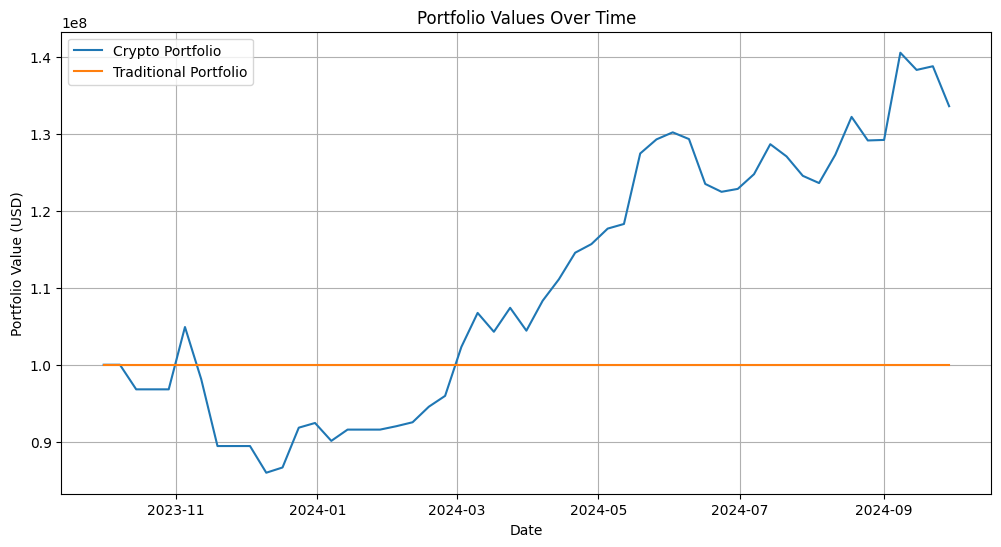

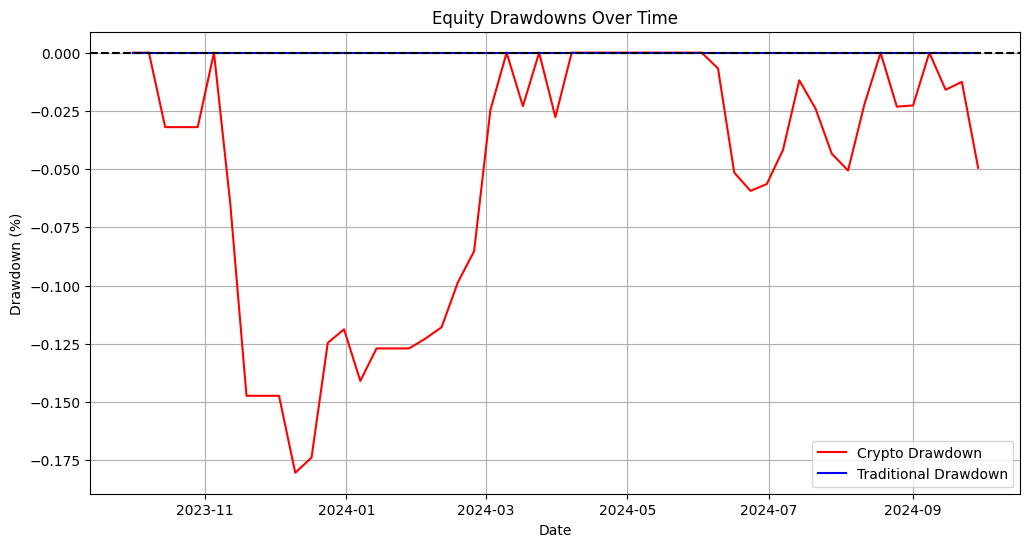

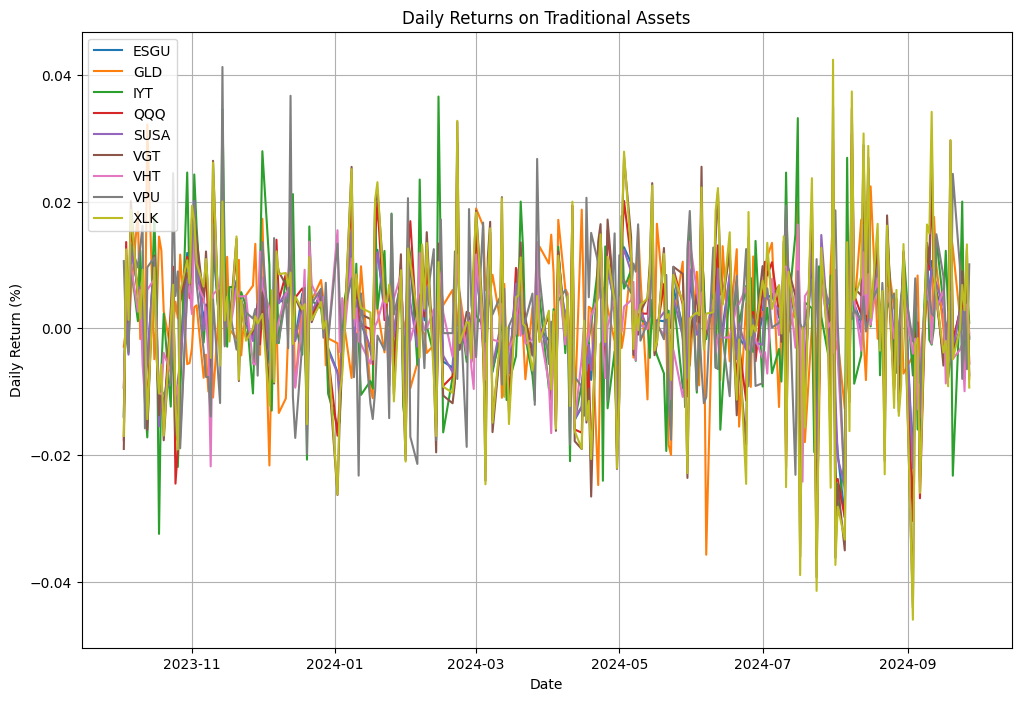

In [30]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
import statsmodels.api as sm
import yfinance as yf

# Logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load price and market cap data from CSV files
def load_price_and_market_cap_data(folder_path, coins):
    price_data = {}
    market_cap_data = {}
    
    for coin in coins:
        logging.info(f"Loading data for {coin}")
        file_path = os.path.join(folder_path, f"{coin}.csv")
        df = pd.read_csv(file_path, parse_dates=['Start'], index_col='Start')
        
        # Log the number of loaded rows for this coin
        logging.info(f"Loaded {len(df)} rows for {coin}")
        
        # Store close prices for price data
        price_data[coin] = df['Close']
        
        # Store market cap data
        market_cap_data[coin] = df[['Market Cap', 'Volume']]
    
    # Convert dictionaries to DataFrames
    price_data = pd.DataFrame(price_data)

    # Handle missing values in price data (forward fill or drop)
    logging.info("Forward filling and dropping NaN values in the price data.")
    price_data.ffill(inplace=True)  # Forward fill missing values
    price_data.dropna(inplace=True)  # Drop rows with persistent NaN values

    # Log the date range of the price data
    logging.info(f"Price Data Date Range: {price_data.index.min()} to {price_data.index.max()}")
    
    # Check if we have data for the required backtest period
    if price_data.index.min() > pd.to_datetime(start_date) or price_data.index.max() < pd.to_datetime(end_date):
        logging.warning(f"Price data does not cover the full backtest period from {start_date} to {end_date}")

    market_cap_data = {coin: df for coin, df in market_cap_data.items()}
    
    logging.info(f"Price Data Head:\n{price_data.head()}")
    return price_data, market_cap_data

# Define factor calculation (Momentum, Size, Value)
def calculate_factors(price_data, cap_data, rolling_window=7):
    logging.info("Calculating factors (Momentum, Size, Value)")

    # Momentum: past week return
    momentum = price_data.pct_change(rolling_window).shift(1)
    logging.info(f"Momentum head:\n{momentum.head()}")

    # Size: market cap of the coins
    size = pd.DataFrame({coin: cap_data[coin]['Market Cap'] for coin in cap_data})
    logging.info(f"Size head:\n{size.head()}")

    # Value: inverse of NVT ratio (Market Cap / Volume)
    value = pd.DataFrame({coin: cap_data[coin]['Market Cap'] / cap_data[coin]['Volume'] for coin in cap_data})
    
    # Handle potential divide-by-zero or inf values in NVT ratio
    value.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN
    value.fillna(0, inplace=True)  # Replace NaN values with 0 or another strategy
    logging.info(f"Value (NVT) head before inversion:\n{value.head()}")

    value = 1 / value
    value = value.clip(lower=-1e9, upper=1e9)  # Clip values to a reasonable range
    logging.info(f"Value (after inversion and clipping) head:\n{value.head()}")
    
    return momentum, size, value

# Backtest strategy with dynamic long/short based on signal strength and sentiment
def backtest_strategy(start_date, end_date, initial_investment, price_data, cap_data, rebalance_time='00:00'):
    logging.info("Starting backtest")
    # Initialize portfolio metrics
    portfolio_value = initial_investment
    portfolio_history = []
    returns_history = []
    
    dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    logging.info(f"Backtest dates: {dates}")
    
    # Calculate factors
    momentum, size, value = calculate_factors(price_data, cap_data)

    # Standardize factors (handle NaN and inf values)
    scaler = StandardScaler()
    
    # Apply StandardScaler while handling NaN values
    logging.info("Standardizing factors.")
    momentum_std = pd.DataFrame(scaler.fit_transform(momentum.fillna(0)), index=momentum.index, columns=momentum.columns)
    size_std = pd.DataFrame(scaler.fit_transform(size.fillna(0)), index=size.index, columns=size.columns)
    value_std = pd.DataFrame(scaler.fit_transform(value.fillna(0)), index=value.index, columns=value.columns)
    
    # Combine factors (equal weight)
    combined_signal = (momentum_std + size_std + value_std) / 3
    logging.info(f"Combined signal head:\n{combined_signal.head()}")
    
    # Restrict signals to the backtest period (starting from start_date)
    combined_signal = combined_signal.loc[start_date:end_date]
    
    for date in dates:
        # Use only the date without time
        portfolio_date = date
        logging.info(f"Rebalancing for date: {portfolio_date}")
        
        if portfolio_date in combined_signal.index:
            signals = combined_signal.loc[portfolio_date]
            logging.info(f"Signals on {portfolio_date}:\n{signals}")
            
            # Check if there are any valid signals
            if signals.isna().all():
                logging.warning(f"No valid signals on {portfolio_date}. Skipping this date.")
                # Append current portfolio value and zero return
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue
            
            # Split signals dynamically based on their strength
            long_threshold = 0.5  # Go long if signal > 0.5
            short_threshold = -0.5  # Go short if signal < -0.5
            
            # Dynamic long/short allocation based on signal strength
            long_coins = signals[signals > long_threshold].index
            short_coins = signals[signals < short_threshold].index
            
            # If no strong short signals, skip shorting
            if len(short_coins) == 0:
                logging.info(f"No strong short signals on {portfolio_date}. Not shorting.")
            
            # If no strong long signals, skip longing
            if len(long_coins) == 0:
                logging.info(f"No strong long signals on {portfolio_date}. Not longing.")
            
            # Ensure there are coins to long or short
            if len(long_coins) == 0 and len(short_coins) == 0:
                logging.warning(f"No strong signals to act upon on {portfolio_date}. Skipping.")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue
            
            # Compute value-weighted allocation
            total_market_cap = size.loc[portfolio_date, long_coins].sum() if len(long_coins) > 0 else 1
            weights = size.loc[portfolio_date, long_coins] / total_market_cap if len(long_coins) > 0 else pd.Series(0, index=long_coins)
            
            # Log market cap and weights for long positions
            logging.info(f"Market cap for long coins:\n{size.loc[portfolio_date, long_coins]}")
            logging.info(f"Weights for long positions:\n{weights}")

            try:
                # Find the next trading day after portfolio_date
                future_dates = price_data.index[price_data.index > portfolio_date]
                if future_dates.empty:
                    logging.warning(f"No future price data available after {portfolio_date}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue
                next_date = future_dates[0]
                
                # Ensure next_date is within the price_data index
                if next_date not in price_data.index:
                    logging.warning(f"No price data for the next day after {portfolio_date}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue

                # Calculate long returns
                long_price_current = price_data.loc[portfolio_date, long_coins]
                long_price_next = price_data.loc[next_date, long_coins]
                long_returns = (long_price_next / long_price_current - 1) * weights
                long_return_total = long_returns.sum()
                
                # Calculate short returns
                short_return_total = 0.0
                if len(short_coins) > 0:
                    short_price_current = price_data.loc[portfolio_date, short_coins]
                    short_price_next = price_data.loc[next_date, short_coins]
                    short_returns = (short_price_next / short_price_current - 1)
                    short_return_total = short_returns.mean() if not short_returns.empty else 0.0
                
            except Exception as e:
                logging.error(f"Error calculating returns: {e}")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue

            # Update portfolio value
            weekly_return = long_return_total - short_return_total
            portfolio_value *= (1 + weekly_return)
            
            logging.info(f"Weekly return: {weekly_return}")
            logging.info(f"Updated portfolio value: {portfolio_value}")
            
            # Record portfolio history
            portfolio_history.append(portfolio_value)
            returns_history.append(weekly_return)
        else:
            logging.warning(f"No signal data for {portfolio_date}. Skipping.")
            portfolio_history.append(portfolio_value)
            returns_history.append(0.0)

    # Convert history to DataFrame
    if portfolio_history:
        portfolio_history_df = pd.DataFrame(portfolio_history, index=dates, columns=['Portfolio Value'])
    else:
        logging.warning("No portfolio history recorded.")
        portfolio_history_df = pd.DataFrame(columns=['Portfolio Value'], index=dates)
    
    return portfolio_history_df, returns_history

# Performance Metrics
# Performance Metrics with S&P 500 as Benchmark
def calculate_metrics(portfolio_history, returns_history, start_date, end_date):
    """
    Calculate Sharpe Ratio, Beta, and Alpha for the backtested portfolio.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    - returns_history (list): List of weekly returns.
    - start_date (str): Start date of the backtest in 'YYYY-MM-DD' format.
    - end_date (str): End date of the backtest in 'YYYY-MM-DD' format.

    Returns:
    - sharpe_ratio (float): Annualized Sharpe Ratio.
    - beta (float): Beta of the portfolio relative to S&P 500.
    - alpha (float): Alpha of the portfolio.
    """
    # Convert returns_history to a pandas Series with backtest dates as index
    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    returns_series = pd.Series(returns_history, index=backtest_dates)
    logging.info(f"Backtest dates index for returns_series:\n{returns_series.index}")
    
    # Calculate Sharpe Ratio
    returns_cleaned = returns_series.dropna()  # Drop NaN values
    logging.info(f"Cleaned returns history: {returns_cleaned}")
    
    if len(returns_cleaned) == 0:
        logging.warning("No returns to calculate metrics.")
        return np.nan, np.nan, np.nan
    
    sharpe_ratio = np.mean(returns_cleaned) / np.std(returns_cleaned) * np.sqrt(52)  # Annualized Sharpe Ratio (52 weeks)
    
    # Fetch S&P 500 data using yfinance
    sp500_ticker = '^GSPC'
    logging.info(f"Fetching S&P 500 data from {start_date} to {end_date} using yfinance.")

    try:
        sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        logging.error(f"Error fetching S&P 500 data: {e}")
        return sharpe_ratio, np.nan, np.nan

    if sp500_data.empty:
        logging.error("Fetched S&P 500 data is empty. Please check the ticker and date range.")
        return sharpe_ratio, np.nan, np.nan

    # Ensure the data is sorted in ascending order
    sp500_data.sort_index(inplace=True)
    logging.info("Sorted S&P 500 data in ascending order.")

    # Calculate daily returns for S&P 500
    market_returns_daily = sp500_data['Close'].pct_change().dropna()

    # Resample daily market returns to weekly returns (W-SUN) by compounding
    market_returns_weekly = market_returns_daily.resample('W-SUN').agg(lambda x: (1 + x).prod() - 1)
    logging.info(f"Weekly market returns from {start_date} to {end_date}:\n{market_returns_weekly.head()}")

    # Align the indices of returns_history and market_returns_weekly using common dates
    common_dates = returns_series.index.intersection(market_returns_weekly.index)
    aligned_returns_history = returns_series.loc[common_dates]
    aligned_market_returns = market_returns_weekly.loc[common_dates]

    logging.info(f"Common dates after intersection: {common_dates}")
    logging.info(f"Aligned returns history after intersect:\n{aligned_returns_history}")
    logging.info(f"Aligned market returns after intersect:\n{aligned_market_returns}")

    # Ensure both series have no NaN values
    aligned_returns_history = aligned_returns_history.dropna()
    aligned_market_returns = aligned_market_returns.dropna()

    # Re-align indices to ensure they match exactly
    common_dates_final = aligned_returns_history.index.intersection(aligned_market_returns.index)
    aligned_returns_history = aligned_returns_history.loc[common_dates_final]
    aligned_market_returns = aligned_market_returns.loc[common_dates_final]

    logging.info(f"Final common dates after re-intersection: {common_dates_final}")
    logging.info(f"Final aligned returns history:\n{aligned_returns_history}")
    logging.info(f"Final aligned market returns:\n{aligned_market_returns}")

    # Check if we have enough data to run the regression
    if len(aligned_returns_history) < 2:
        logging.warning("Not enough data for regression.")
        return sharpe_ratio, np.nan, np.nan

    # Convert data to float to avoid dtype issues
    aligned_returns_history = aligned_returns_history.astype(float)
    aligned_market_returns = aligned_market_returns.astype(float)

    # Calculate Beta and Alpha using OLS regression
    X = sm.add_constant(aligned_market_returns)  # Adds a constant term to the predictor
    model = OLS(aligned_returns_history, X).fit()
    beta = model.params[aligned_market_returns.name]
    alpha = model.params['const']

    # Optionally, log the regression summary for debugging
    logging.debug(model.summary())

    return sharpe_ratio, beta, alpha

# Plot Portfolio
def plot_portfolio(portfolio_history):
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Equity Drawdown Calculation and Plot
def plot_equity_drawdown(portfolio_history):
    """
    Plot the equity drawdown over time.
    
    Parameters:
    portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    """
    portfolio_history['Max Value'] = portfolio_history['Portfolio Value'].cummax()
    portfolio_history['Drawdown'] = (portfolio_history['Portfolio Value'] - portfolio_history['Max Value']) / portfolio_history['Max Value']
    
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(portfolio_history.index, portfolio_history['Drawdown'], color='red', alpha=0.3)
    plt.title('Equity Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    # plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()

# Daily Returns on Assets Calculation and Plot
def plot_daily_returns_on_assets(price_data):
    """
    Plot the daily returns on assets over time.
    
    Parameters:
    price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency indexed by date.
    """
    daily_returns = price_data.pct_change().dropna()  # Calculate daily returns
    plt.figure(figsize=(12, 8))
    plt.plot(daily_returns.index, daily_returns)
    plt.title('Daily Returns on Assets')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.grid(True)
    plt.legend(price_data.columns, loc='upper left')
    plt.show()

# Plot Portfolio Value with Drawdown and Daily Returns
def plot_portfolio_and_drawdown(portfolio_history, price_data):
    """
    Plot both the portfolio value and the equity drawdown over time.
    
    Parameters:
    portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency.
    """
    # Plot portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot equity drawdown
    plot_equity_drawdown(portfolio_history)

    # Plot daily returns on assets
    plot_daily_returns_on_assets(price_data)

# Main execution
if __name__ == "__main__":
    # Parameters
    start_date = "2023-10-01"
    end_date = "2024-09-29"    # Ensure yfinance has data up to this date
    initial_investment = 100_000_000  # 100M USD
    
    # Load data for top 10 cryptocurrencies (excluding USDT and USDC)
    top_10_coins = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TON', 'TRX', 'AVAX']
    folder_path = 'Data'  # Path to CSV files containing market cap data
    
    # Load price and market cap data from CSV files
    price_data, market_cap_data = load_price_and_market_cap_data(folder_path, top_10_coins)
    
    # Backtest the strategy
    portfolio_history, returns_history = backtest_strategy(start_date, end_date, initial_investment, price_data, market_cap_data)
    
    # Calculate performance metrics
    sharpe_ratio, beta, alpha = calculate_metrics(portfolio_history, returns_history, start_date, end_date)
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Beta: {beta:.4f}")
    print(f"Alpha: {alpha:.4f}")
    
    # Plot portfolio value, equity drawdown, and daily returns on assets
    plot_portfolio_and_drawdown(portfolio_history, price_data)